In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import rioxarray as rio
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

In [2]:
path_data = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data')
path_results = os.path.join(os.path.dirname(os.getcwd()), 'results')

In [3]:
# Inputs
osmsites = gpd.read_parquet(os.path.join(path_data, 'is_nl33.parquet'))
sectors = gpd.read_parquet(os.path.join(path_data, 'industrial.parquet'))
substations = gpd.read_parquet(os.path.join(path_data,'substaions_nl33.parquet'))
nuts3 = gpd.read_file(os.path.join(path_data,'NUTS3_Zuid_Holland.shp'))


In [4]:
op = 1.01
ip = 0.25
dam = 1
RP = [1000, 10000]
cif = 'ci'

In [5]:
def clip_raster(raster,vector):
    vector = vector.to_crs(raster.rio.crs)
    geom = vector.geometry
    raster_clipped = raster.rio.clip(geom, from_disk = True)
    return raster_clipped

In [6]:
def match_crs(vector,raster):
    vector = vector.to_crs(raster.rio.crs)
    return vector

In [7]:
def plotter(rp, op, ip, dam, path_data, path_results, nuts3, osmsites, sectors, substations, ax):
    # Results
    floodmap = rio.open_rasterio(os.path.join(path_data,f'rotterdam_event_RP{rp}.tif'))
    ci_df = pd.read_excel(os.path.join(path_results, f'ci_{op}_{ip}_mosek_{rp}_{dam}.xlsx'), index_col = [0])
    os_df = pd.read_excel(os.path.join(path_results, f'osm_industrial_{op}_{ip}_mosek_{rp}_{dam}.xlsx'), index_col = [0])

    # Assigning damage to geo dataframe
    osmsites['flood_fail'] = os_df['flood_fail']
    osmsites['power_fail'] = os_df['power_fail']
    substations['flood_fail'] = ci_df['flood_fail']

    sectors_centroids = sectors.copy()
    sectors_centroids['geometry'] = sectors_centroids.geometry.centroid

    sectors_in_osmsite = gpd.sjoin(
    sectors_centroids,
    osmsites[['geometry', 'osmid', 'flood_fail', 'power_fail']],
    how='inner',
    predicate='within'
    )

    sectors_in_osmsite = sectors_in_osmsite.reset_index(drop=True)
    substations_centroids = substations.copy()
    substations_centroids['geometry'] = substations_centroids.geometry.centroid

    nuts3 = match_crs(nuts3,floodmap)
    nuts_of_interest = ['NL33C']
    nuts_of_interest_df  = nuts3[nuts3['NUTS_ID'].isin(nuts_of_interest)]

    floodmap_clipped = clip_raster(floodmap,nuts_of_interest_df)

    # 1. Ensure same CRS
    nuts_of_interest_df = nuts_of_interest_df.to_crs(floodmap_clipped.rio.crs)
    
    # 2. Extract the geometries as a list of shapely geometries
    geometries = nuts_of_interest_df.geometry.values
    
    # 3. Clip the raster by the polygon geometry
    raster_clipped_exact = floodmap_clipped.rio.clip(geometries, nuts_of_interest_df.crs, drop=True, invert=False)


    
    nuts_of_interest_df = nuts_of_interest_df.to_crs(floodmap_clipped.rio.crs)
    raster_data = raster_clipped_exact.values.squeeze()
    raster_masked = np.ma.masked_where(np.isnan(raster_data), raster_data)
    
    xmin, ymin, xmax, ymax = (
        floodmap_clipped.x.min().item(),
        floodmap_clipped.y.min().item(),
        floodmap_clipped.x.max().item(),
        floodmap_clipped.y.max().item()
    )
    

    ax.imshow(raster_masked, extent=[xmin, xmax, ymin, ymax], cmap='Blues')
    ax.set_axis_off()
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    
    # Plotting Zuid Holland
    nuts3 = match_crs(nuts3,floodmap)
    nuts3.plot(ax=ax, color='GREY', alpha=0.2)
    
    # Plotting all the firms
    sectors_in_osmsite = match_crs(sectors_in_osmsite,floodmap)
    sectors_in_osmsite.plot(ax=ax, color='#a99985', markersize = 0.3)
    
    # Plotting all the substations
    substations_centroids = match_crs(substations_centroids,floodmap)
    # substations_centroids.plot(ax=ax, color='pink', markersize = 20,  marker='o' )
    
    ## Plotting power failed firsm
    sectors_in_osmsite_power = sectors_in_osmsite[sectors_in_osmsite['power_fail'] == 0]
    sectors_in_osmsite_power.plot(ax=ax, color='red', markersize = 2)
    
    ## Plotting flooded firsm
    sectors_in_osmsite_flood = sectors_in_osmsite[sectors_in_osmsite['flood_fail'] == 0]
    sectors_in_osmsite_flood.plot(ax=ax, color='blue', markersize = 2)
    
    # Plotting fialed substations
    substations_centroids_failed = substations_centroids[substations_centroids['flood_fail'] == 0]
    substations_centroids_failed.plot(ax=ax, color='black', markersize = 20,  marker='x' )


C:\Users\sva100\AppData\Local\Temp\ipykernel_20484\1572386844.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sectors_centroids['geometry'] = sectors_centroids.geometry.centroid
C:\Users\sva100\AppData\Local\Temp\ipykernel_20484\1572386844.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  substations_centroids['geometry'] = substations_centroids.geometry.centroid
C:\Users\sva100\AppData\Local\Temp\ipykernel_20484\1572386844.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sectors_centroids['geometry'] = sectors_centroids.geometry.centroid
C:\Users\sva100\AppD

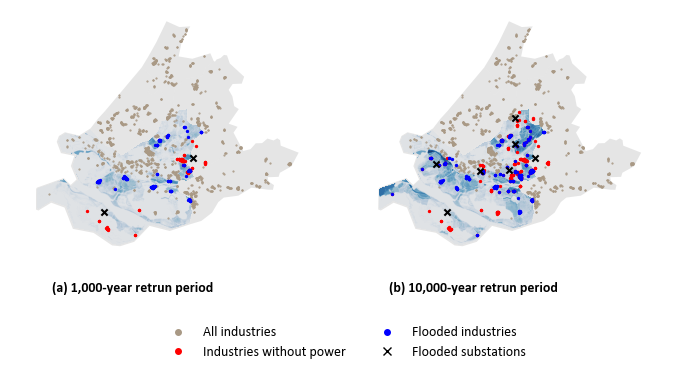

In [8]:
# Create the figure
fig = plt.figure(figsize=(7, 4))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.3])  # Smaller height for legend row

# Define axes
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
legend_ax = fig.add_subplot(gs[1, :])  # Combine both bottom columns into one


ax0.text(0.35, -0.1, '(a) 1,000-year retrun period', transform=ax0.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10, family='calibri')

ax1.text(0.35, -0.1, '(b) 10,000-year retrun period ', transform=ax1.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10, family='calibri')

# --- Plot your maps using the custom plotter function ---
plotter(RP[0], op, ip, dam, path_data, path_results, nuts3, osmsites, sectors, substations, ax=ax0)
plotter(RP[1], op, ip, dam, path_data, path_results, nuts3, osmsites, sectors, substations, ax=ax1)

# --- Create custom legend ---
legend_elements = [
    mlines.Line2D([], [], color='#a99985', marker='o', linestyle='None', markersize=4, label='All industries'),
    mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=4, label='Industries without power'),
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=4, label='Flooded industries'),
    mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=6, label='Flooded substations'),
]

# Plot the legend
legend_ax.legend(
    handles=legend_elements,
    loc='center',
    ncol=2,
    frameon=False,
    prop={'family': 'calibri', 'size': 10}
)
legend_ax.axis('off')  # Hide the legend axis itself

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Optional tweak spacing between rows
plt.savefig('Figure1_spatial_damage.png', dpi = 300, bbox_inches = 'tight')
plt.show()